In [1]:
from utils import *

%load_ext autoreload
%autoreload 2

In [88]:
files_list = ['./xaa', './xak', './xau']

text = ''
for filename in files_list:
    with open(filename, 'r') as textfile:
        text += textfile.read()

text = re.sub(r'[\-\d%,:;"\'#&$!\?\+=\*\(\)/\{\}\^<>@\[\]_\\`~]+','',text)
text = re.sub(r'[\.]+',' ',text)
text_sentences = re.split(r'\s', text)
text_sentences = [tk.lower() for tk in filter(lambda x: x!='', text_sentences)]
with open('wiki', 'w') as wikifile:
    wikifile.write(' '.join(text_sentences))

In [79]:
files_list = ['./xaa', './xak', './xau']

text = ''
for filename in files_list:
    with open(filename, 'r') as textfile:
        text += textfile.read()

text = re.sub(r'[\-\d%,:;"\'#&$!\?\+=\*\(\)/\{\}\^<>@\[\]_\\`~]+','',text)
text = re.sub(r'[\.]+',' ',text)
text_sentences = re.split(r'\s', text)
text_sentences = [tk.lower() for tk in filter(lambda x: x!='', text_sentences)]
vocab = Vocabulary.from_corpus([text_sentences],cutoff_freq=3)
print(vocab)

<Vocabulary(size=53277)>


In [82]:
corpus = [text_sentences]
cutoff_freq = 3
window_size_list = [8]
batch_size = 512

state_dict = None
device = 'cuda:1'
paralelize = False
embedding_dim_list = [200]

sk_trainers = []
for window_size in window_size_list:
    embedding_dim_trainers = []
    for embedding_dim in embedding_dim_list:
        sk_trainer = SkipGramTrainer(corpus, cutoff_freq, window_size, batch_size)
        sk_trainer.InitModel(state_dict=state_dict, device=device, paralelize=paralelize, embedding_dim=embedding_dim)
        embedding_dim_trainers.append(sk_trainer)
    sk_trainers.append(embedding_dim_trainers)

SkipGram trainer created:
Window size: 8
Number of samples: 4414588
Vocabulary Size: 53277
Number of batches: 8623
Number of samples per batch: 512

Dispositivo seleccionado: cuda:1
Dimensión del espacio de los embeddings: 200


In [83]:
algorithm = 'Adam'
epochs = 300
sample_loss_every = 100
learning_rate = 5e-4

for trainer_list in sk_trainers:
    for trainer in trainer_list:
        trainer.Train(algorithm=algorithm, epochs=epochs, sample_loss_every=sample_loss_every, lr=learning_rate)

Starting training...
Optimization method: Adam
Learning Rate: 0.0005
Number of epochs: 300
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 86997.4453125
Epoch: 1, Batch number: 100, Loss: 81681.53125
Epoch: 1, Batch number: 200, Loss: 76392.96875
Epoch: 1, Batch number: 300, Loss: 74385.3984375
Epoch: 1, Batch number: 400, Loss: 72322.390625
Epoch: 1, Batch number: 500, Loss: 70645.1484375
Epoch: 1, Batch number: 600, Loss: 70478.125
Epoch: 1, Batch number: 700, Loss: 68623.7890625
Epoch: 1, Batch number: 800, Loss: 67488.8984375
Epoch: 1, Batch number: 900, Loss: 67539.328125
Epoch: 1, Batch number: 1000, Loss: 65785.890625
Epoch: 1, Batch number: 1100, Loss: 65207.91015625
Epoch: 1, Batch number: 1200, Loss: 63928.4375
Epoch: 1, Batch number: 1300, Loss: 64141.95703125
Epoch: 1, Batch number: 1400, Loss: 64051.4609375
Epoch: 1, Batch number: 1500, Loss: 62376.48828125
Epoch: 1, Batch number: 1600, Loss: 62330.6796875
Epoch: 1, Batch number: 1700, Loss: 63410.01171875
Epo

<IPython.core.display.Javascript object>


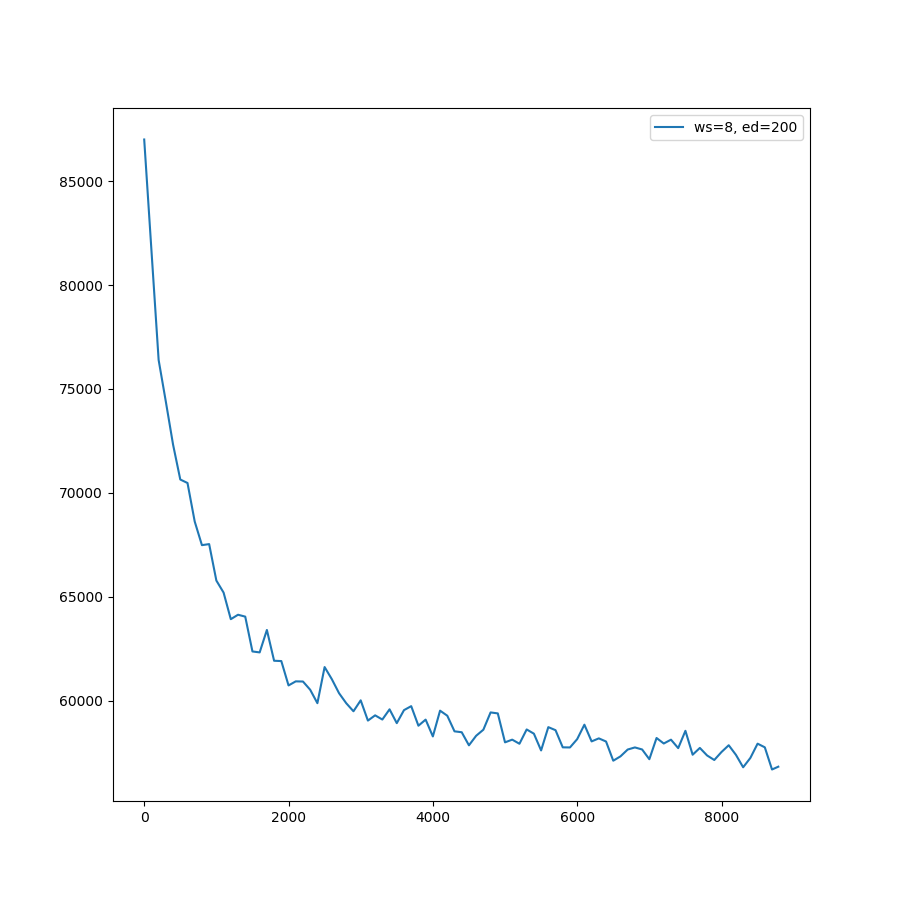

In [84]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9., 9.)

fig, ax = plt.subplots()
for trainer_list in sk_trainers:
    for trainer in trainer_list:
        ax.plot(trainer.loss_history['iter'],trainer.loss_history['loss'],
                label='ws={}, ed={}'.format(trainer.window_size, trainer.embedding_dim))
ax.legend()

In [58]:
import pickle 

with open('./sk_trainers.bin', 'rb') as trainerfile:
    sk_trainers_old = pickle.load(trainerfile)

In [85]:
test_filename = './promptsl40.test'
trainer = sk_trainers[0][0]

with open(test_filename, 'rb') as testfile:
        test_text = testfile.readlines()
    
test_corpus = [['<s>'] + re.split(r'[\t \n]',l.decode('iso-8859-1'))[2:-1] + ['</s>'] for l in test_text]
test_corpus = [token for line in test_corpus for token in line]

# Probabilidad de los unigramas:
test_vocab = Vocabulary.from_corpus([test_corpus],cutoff_freq=0)
train_vocab = trainer.dataloader.dataset.vocabulary
unigram_probs = {}
uniform_prob = max(-99.,-float(np.log(len(train_vocab))))
count1, count2 = 0, 0
for tk in test_vocab:
    try:
        idx = train_vocab[tk]
        emb = trainer.model.emb(torch.tensor(idx).to(device=trainer.device))
        out = trainer.model.out.weight.data[idx,:].to(device=trainer.device)
        unigram_scores = trainer.model.out(out)
        unigram_probs[tk] = min(max(-99,(unigram_scores - torch.logsumexp(unigram_scores, dim=0))[idx].item()),0.)
        count1 += 1
    except KeyError:
        unigram_probs[tk] = uniform_prob
        count2 += 1
print(count1, count2)

2450 306
